In [372]:
import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt
import scipy.sparse as sps
import scipy.optimize as sco

# Polynome de degré $n = 2p + 1$ 

## Fonctions

In [373]:
def f(x,h):
    x = x*h
    return 2*x**3 + x**2 + 2 

def g(x,h):
    x = x*h
    return x**3 + 2

def h(x,h):
    x = x*h
    return np.cos(x)

def k(x,h):
    x = x*h
    return x + 1
fonctions_test = [f,g,h,k]

In [395]:
def f(x,h):
    x = x*h
    return 2*x**17 + x**10 - x**2 + 2 # - 1.85

def g(x,h):
    x = x*h
    return 0.5 + np.abs(x - 0.5) #- 0.75

def t(x,h):
    if h == 1 :
        h = 9/10
    x = x*h
    return 1/(1-x) #-1.5

def j(x,h):
    x = x*h
    return 1/ ( 1 + 25*(2*x-1)**2 ) #- 1

def k(x,h):
    x = x*h
    return 10**5 * x**10 * (1-x)**7 + 0.01

def q(x,h):
    x = x*h
    return 10 * (x-1/2)**4 #+ 0.01

def creneau(x,h):
    x = x*h
    return (x<1/4)*0 + (x>3/4)*0 + (1/4<=x)*1 + (x<=3/4)*1

def sinoffset(x,h):
    x = x*h
    return np.sin(x)+1.2

def gaussienne(x,h):
    x = x*h
    m = 1/2
    sigma = 1/10
    return np.exp(-(x-m)**2/2/sigma**2) / (2*np.pi)/sigma

fonctions_test = [f,g,t,j,k,q,creneau,sinoffset,gaussienne]

## Initialisation

In [396]:
def init_X(p):
    # initialise les points alpha0 et beta0 (3.10) 
    i = np.linspace(0,p,p+1)
    X = np.zeros(2*(p+1))
    X[:p+1] = 1/2*(1-np.cos((2*i+1)*np.pi/(2*p+1)))
    X[p+1:] = 1/2*(1-np.cos(2*i*np.pi/(2*p+1)))
    return X

In [397]:
def test_init(p):
    X = init_X(p)
    plt.plot(X[:p+1],np.ones(len(X[:p+1])),'ob')
    plt.plot(X[p+1:],np.ones(len(X[p+1:])),'or')

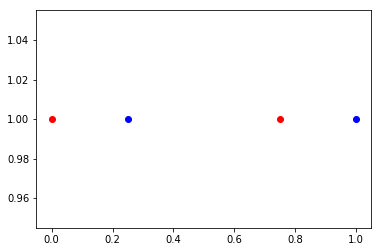

In [398]:
p = 1
test_init(p)

## Operateur S

In [399]:
def S (p,eps,X0):
    # séparation en alpha et beta
    alpha = X0[:p]
    beta = X0[p:]

    # creation des delta pour alpha et beta
    delta_alpha = np.concatenate((alpha,[1]))
    delta_alpha[1:] -= alpha
    
    delta_beta = - np.concatenate(([0],beta))
    delta_beta[:-1] += beta
    delta_beta[-1] += 1 
    
    # creation des delta_tilde pour alpha et beta
    delta_alpha_t = np.zeros(p+1)
    delta_beta_t = np.zeros(p+1)
    for i in range (p+1):
        delta_alpha_t[i] = max(delta_alpha[i],2*eps)
        delta_beta_t[i] = max(delta_beta[i],2*eps)

    delta_alpha_t = delta_alpha_t / np.sum(delta_alpha_t)
    delta_beta_t = delta_beta_t / np.sum(delta_beta_t)

    # mise a jour des alpha et beta, directement dans x
    X = np.zeros(2*p)
    X[0] = delta_alpha_t[0]
    X[p] = delta_beta_t[0]
    for i in range (1,p):
        X[i] = X[i-1] + delta_alpha_t[i]
        X[i+p] = X[i-1+p] + delta_beta_t[i]
    
    return X

In [400]:
def test_S(a):
    print(a)
    Speps = S(4,0.1,a)
    print(Speps)

    plt.plot(Speps[:4],np.ones(4),'or')
    plt.plot(Speps[4:],np.ones(4),'ob')

[0.1, 0.35, 0.5, 0.8, 0.07, 0.39, 0.65, 0.85]
[0.17391304 0.39130435 0.56521739 0.82608696 0.16949153 0.44067797
 0.66101695 0.83050847]


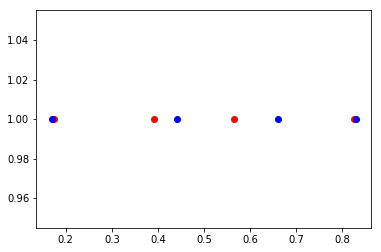

In [401]:
a = [0.1,0.35,0.5,0.8,0.07,0.39,0.65,0.85]
test_S(a)

# Algorithme

In [402]:
def Jp(p,f,h,X,epsilon):
    # calcule la jacobienne
    i = np.linspace(0,p-1,p)
    theta_i = 2*(p-i)*np.pi/(2*p+1)
    D_alpha = 2*p*np.cos(p*theta_i)/(np.cos(theta_i)-1) + np.sin(p*theta_i)/np.sin(theta_i) * 2 * (p - 1/(np.cos(theta_i)-1))
    
    i = np.linspace(1,p,p)
    eta_i = (2*(p-i)+1)*np.pi/(2*p+1)
    D_beta = 2*p*np.cos(p*eta_i)/(np.cos(eta_i)+1) + np.sin(p*eta_i)/np.sin(eta_i) * 2* (p + 1/(np.cos(eta_i)+1))

    feps = max( np.max(f(X,h)),epsilon) #cf partie 4
    return  np.sqrt(feps) * sps.diags(np.concatenate((D_alpha,D_beta))).toarray()

def b_beta (p,f,h,beta,x,epsilon):
    # calcule la fonction b[beta] au point x
    res = 0
    for i in range (p+1):
        somme = (-1)**(i+p)*np.sqrt(max(f(beta[i],h),epsilon)/(1-beta[i])) 
        pro = 1
        for j in range (p+1):
            if i != j :
                pro *=  (x - beta[j])/(beta[i]-beta[j])
        somme *= pro
        res  += somme
    return res
  

def a_alpha (p,f,h,alpha,x,epsilon):
    # calcule la fonction a[alpha] au point x
    res = 0
    for i in range (p+1):
        somme = (-1)**(i+p)*np.sqrt(max(f(alpha[i],h),epsilon)/(alpha[i])) 
        pro = 1
        for j in range (p+1):
            if i != j :
                pro *=  (x - alpha[j])/(alpha[i]-alpha[j])
        somme *= pro
        res += somme
    return res
     
def f_theta(X,p,f,h,espilon):
    # fonction à minimiser - [a[alpha](beta), b[beta](alpha)]
    alpha = X[:p]
    alpha_1 = np.concatenate((alpha,[1]))
    beta = X[p:]
    beta_0 = np.concatenate(([0],beta))
    return np.concatenate(( b_beta(p,f,h,beta_0,alpha,epsilon), a_alpha(p,f,h,alpha_1,beta,epsilon) ))

In [403]:
def Newton_Raphson (p,f,h,epsi,epsilon,eps=1e-12,itermax=100):
    X = init_X(p) 
    X = np.concatenate((X[:p],X[p+2:]))
    k=0
    err=2*eps
    Residus = []
    while err > eps and itermax > k :
        X0 = np.copy(X)
        #print(f_theta(X,p,f,h,epsilon))
        d = npl.solve(Jp(p,f,h,X,epsilon),f_theta(X,p,f,h,epsilon))
        X = X - d
        X = S(p,epsi,X)
        #print(f_theta(X,p,f,h,epsilon))
        k+=1
        err = npl.norm(X-X0)/npl.norm(X0)
        Residus += [err]
    #print(k)
    return X,k,Residus


In [404]:
def epsi_S(p):
    #permet de calculer le epsilon propre à l'opérateur Séparateur
    i = np.linspace(0,2*p+1,2*p+2)
    gamma = 1/2*(1-np.cos(i*np.pi/(2*p+1)))
    return min( 1/2/(p+1), np.min((gamma[1:]-gamma[:-1])/3))

def pn(x,ap,bp): 
    #retourne le polynome à partir de la décompo de Lukas
    return x * ap**2 + (1-x) * bp**2
    
def approxh(x,p,f,h,epsilon):
    # reconstruit le polynome le plus interpolant
    epsi = epsi_S(p)
    #X = sco.fsolve(f_theta,np.array([1/4,3/4]), args=(p,f,h,epsilon))
    #X = S(p,epsi,X)
    X,itermax,residus = Newton_Raphson(p,f,h,epsi,epsilon)
    #print("ftheta :",f_theta(X,p,f,h,epsilon))
    X  = np.concatenate(( X[:p],[1],[0],X[p:]))

    ap = a_alpha(p,f,h,X[:p+1],x,epsilon)
    bp = b_beta(p,f,h,X[p+1:],x,epsilon)
    
    return pn(x,ap,bp),X

In [405]:
def test_approx(p,f,h,espilon,affichage):
    x = np.linspace(0,1,501)
    px, interp = approxh(x,p,f,h,epsilon)

    Ap = a_alpha(p,f,h,interp[:p+1],interp,epsilon)
    Bp = b_beta(p,f,h,interp[p+1:],interp,epsilon)
    
    fx = f(x,h) 
    
    if affichage == 1 : 
        plt.plot(x,fx,label="f(x)")
        plt.plot(x,px,label="p(x)")
        plt.plot(interp,f(interp,h),'ob')
        plt.plot(interp, pn(interp,Ap,Bp),'or')
        plt.legend()
        name = str(f).split(' ')
        plt.title("Fonction "+name[1]+", p = "+str(p)+", h = "+str(h)+", epsilon = "+str(epsilon))
        plt.show()
    
    return px,fx

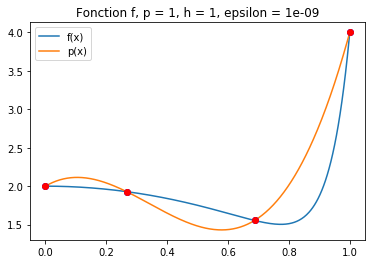

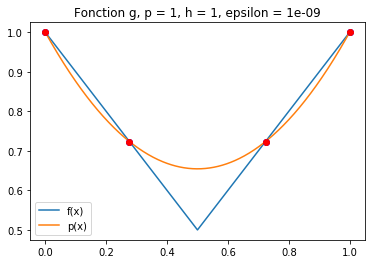

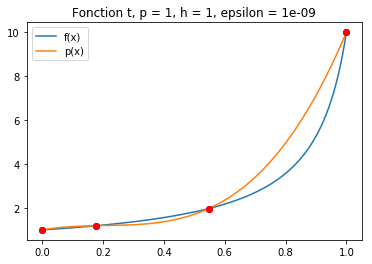

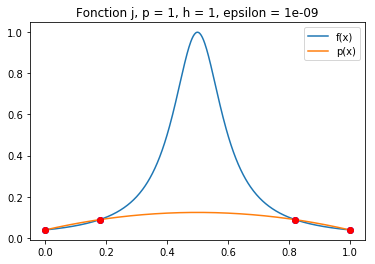

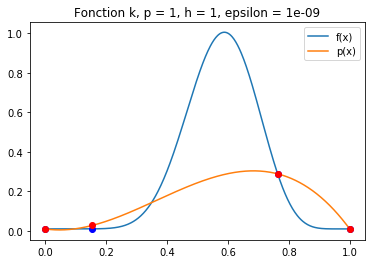

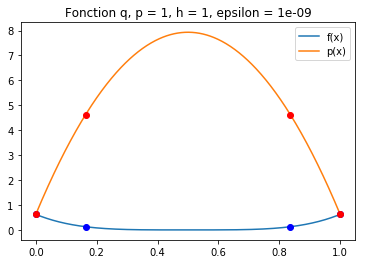

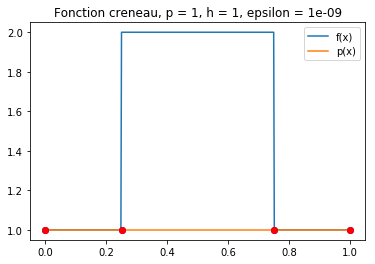

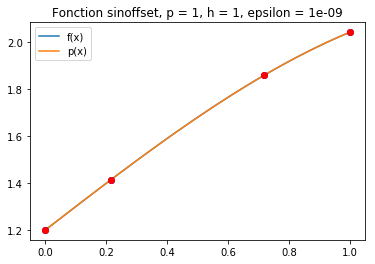

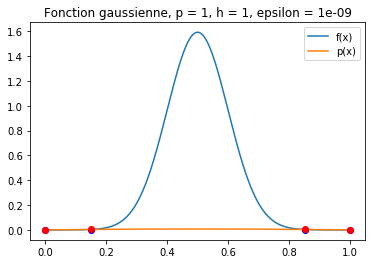

In [406]:
h = 1
p = 1
epsilon=1e-9

for fonctions in fonctions_test : 
    test_approx(p,fonctions,h,epsilon,1)

--------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

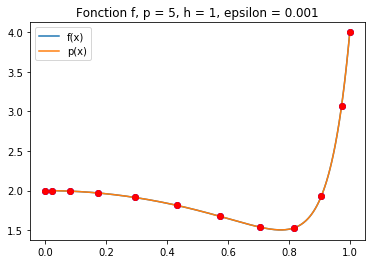

Norme de l'erreur :  n2 = 0.001443841801683919  ; ninf =  0.00010822207399630024 



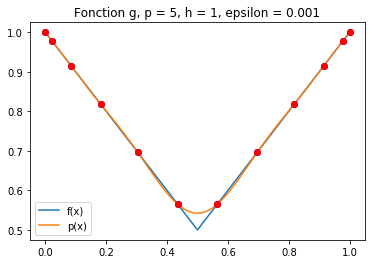

Norme de l'erreur :  n2 = 0.18361892402081467  ; ninf =  0.04224839588061169 



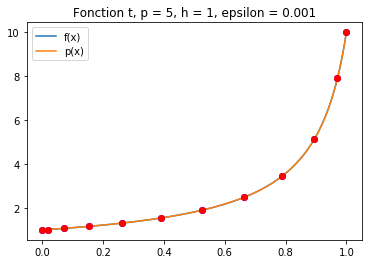

Norme de l'erreur :  n2 = 0.06282536655210628  ; ninf =  0.0097004035940218 



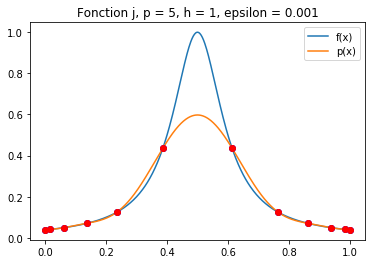

Norme de l'erreur :  n2 = 2.650999119574286  ; ninf =  0.40245477202756397 



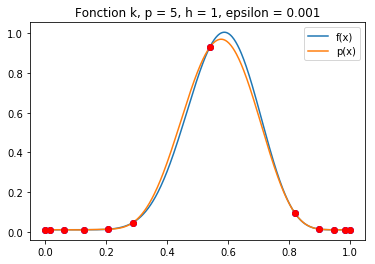

Norme de l'erreur :  n2 = 0.5742445974432961  ; ninf =  0.05621786559895037 



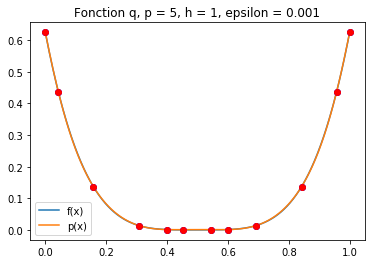

Norme de l'erreur :  n2 = 0.022313902298343975  ; ninf =  0.0020414469573094007 



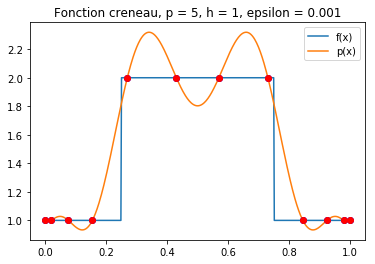

Norme de l'erreur :  n2 = 5.2836663284185175  ; ninf =  0.8037928748679835 



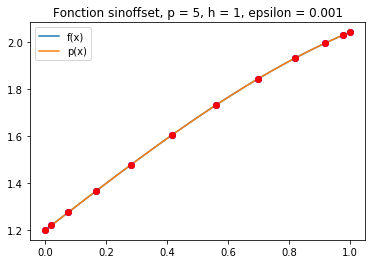

Norme de l'erreur :  n2 = 1.641929396652855e-14  ; ninf =  2.220446049250313e-15 



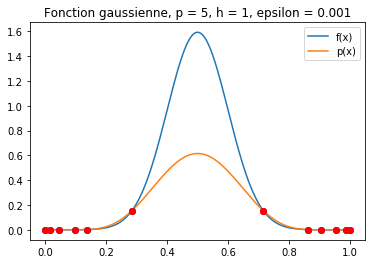

Norme de l'erreur :  n2 = 8.485851245133265  ; ninf =  0.9763357841055573 



In [407]:
h = 1
p = 5
epsilon=0.001

for fonctions in fonctions_test : 
    px,fx = test_approx(p,fonctions,h,epsilon,1)
    print("Norme de l'erreur :  n2 =", npl.norm(px-fx), " ; ninf = ", npl.norm(px-fx,np.inf),"\n")

# Tests

### Variation de p

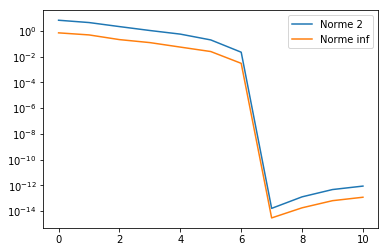

In [408]:
h = 1
epsilon=0.001
p = np.arange(1,12,1)


Err = np.zeros((2,len(p)))

for i in range(len(p)):
    px,fx = test_approx(p[i],k,h,epsilon,0)
    Err[0,i] = npl.norm(px-fx)
    Err[1,i] = npl.norm(px-fx,np.inf)
    
plt.semilogy(Err[0,:],label="Norme 2")
plt.semilogy(Err[1,:],label="Norme inf")
plt.legend()

### Variation de h

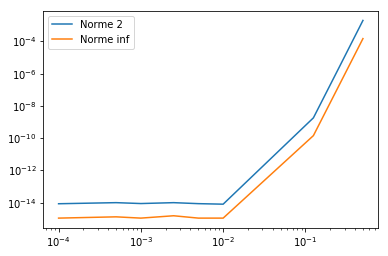

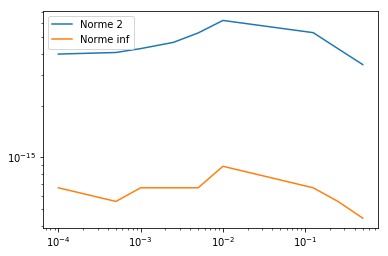

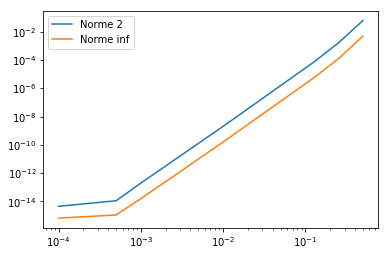

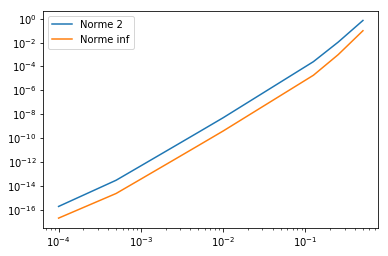

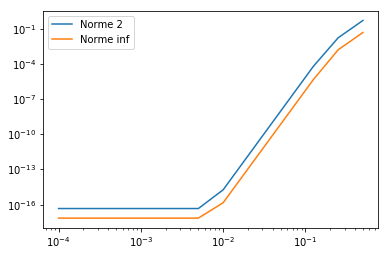

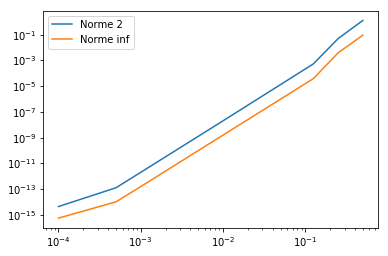

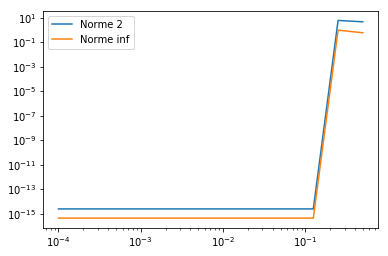

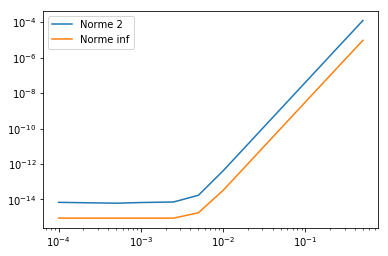

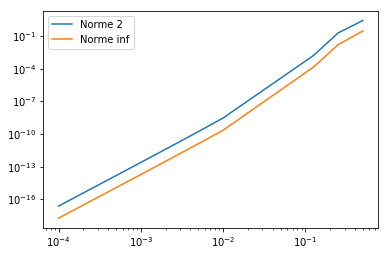

In [409]:
h = [1/2,1/4,1/8,1/100,1/200,1/400,1/1000,1/2000,1/10000]
p = 1
epsilon = 1e-9
Err = np.zeros((2,len(h)))

for f in fonctions_test : 
    for i in range(len(h)):
        px,fx = test_approx(p,f,h[i],epsilon,0)
        Err[0,i] = npl.norm(px-fx)
        Err[1,i] = npl.norm(px-fx,np.inf)

    plt.loglog(h,Err[0,:],label="Norme 2")
    plt.loglog(h,Err[1,:],label="Norme inf")
    plt.legend()
    plt.show()
    

Pb sur le dernier : stagne à 10-2
Origine du pb possible : nb de points insuffisants et/ou epsilon trop grand (si h grand la fonction trop proche de 0 => valeur cachée dans epsilon

### Fonction négative en partie

In [363]:
def q(x,h,l):
    x = x*h
    return 10 * (x-1/2)**4 + l

In [364]:
def Jp(p,f,h,arg,X,epsilon):
    i = np.linspace(0,p-1,p)
    theta_i = 2*(p-i)*np.pi/(2*p+1)
    D_alpha = 2*p*np.cos(p*theta_i)/(np.cos(theta_i)-1) + np.sin(p*theta_i)/np.sin(theta_i) * 2 * (p - 1/(np.cos(theta_i)-1))
    
    i = np.linspace(1,p,p)
    eta_i = (2*(p-i)+1)*np.pi/(2*p+1)
    D_beta = 2*p*np.cos(p*eta_i)/(np.cos(eta_i)+1) + np.sin(p*eta_i)/np.sin(eta_i) * 2* (p + 1/(np.cos(eta_i)+1))

    feps = max( np.max(f(X,h,arg)),epsilon)
    return  np.sqrt(feps) * sps.diags(np.concatenate((D_alpha,D_beta))).toarray()

def b_beta (p,f,h,arg,beta,x,epsilon):
    res = 0
    for i in range (p+1):
        somme = (-1)**(i+p)*np.sqrt(max(f(beta[i],h,arg),epsilon)/(1-beta[i])) 
        pro = 1
        for j in range (p+1):
            if i != j :
                pro *=  (x - beta[j])/(beta[i]-beta[j])
        somme *= pro
        res  += somme
    return res
  

def a_alpha (p,f,h,arg,alpha,x,epsilon):
    res = 0
    for i in range (p+1):
        somme = (-1)**(i+p)*np.sqrt(max(f(alpha[i],h,arg),epsilon)/(alpha[i])) 
        pro = 1
        for j in range (p+1):
            if i != j :
                pro *=  (x - alpha[j])/(alpha[i]-alpha[j])
        somme *= pro
        res += somme
    return res
     
def f_theta(X,p,f,h,arg,espilon):
    alpha = X[:p]
    alpha_1 = np.concatenate((alpha,[1]))
    beta = X[p:]
    beta_0 = np.concatenate(([0],beta))
    return np.concatenate(( b_beta(p,f,h,arg,beta_0,alpha,epsilon), a_alpha(p,f,h,arg,alpha_1,beta,epsilon) ))

In [365]:
def Newton_Raphson (p,f,h,arg,epsi,epsilon,eps=1e-12,itermax=100):
    X = init_X(p) 
    X = np.concatenate((X[:p],X[p+2:]))
    k=0
    err=2*eps
    while err > eps and itermax > k :
        X0 = np.copy(X)
        #print(f_theta(X,p,f,h,epsilon))
        d = npl.solve(Jp(p,f,h,arg,X,epsilon),f_theta(X,p,f,h,arg,epsilon))
        X = X - d
        X = S(p,epsi,X)
        #print(f_theta(X,p,f,h,epsilon))
        k+=1
        err = npl.norm(X-X0)/npl.norm(X0)
    print(k)
    return X

In [366]:
def epsi_S(p):
    i = np.linspace(0,2*p+1,2*p+2)
    gamma = 1/2*(1-np.cos(i*np.pi/(2*p+1)))
    return min( 1/2/(p+1), np.min(gamma[1:]-gamma[:-1])/3)

def pn(x,ap,bp): 
    return x * ap**2 + (1-x) * bp**2
    
def approxh(x,p,f,h,arg,epsilon):
    epsi = epsi_S(p)
    #X = sco.fsolve(f_theta,np.array([1/4,3/4]), args=(p,f,h,epsilon))
    #X = S(p,epsi,X)
    X = Newton_Raphson(p,f,h,arg,epsi,epsilon)
    print("ftheta :",f_theta(X,p,f,h,arg,epsilon))
    X  = np.concatenate(( X[:p],[1],[0],X[p:]))

    ap = a_alpha(p,f,h,arg,X[:p+1],x,epsilon)
    bp = b_beta(p,f,h,arg,X[p+1:],x,epsilon)
    
    return pn(x,ap,bp),X

In [367]:
def test_approx(p,f,h,arg,espilon,affichage):
    x = np.linspace(0,1,501)
    px, interp = approxh(x,p,f,h,arg,epsilon)
   
    Ap = a_alpha(p,f,h,arg,interp[:p+1],interp,epsilon)
    Bp = b_beta(p,f,h,arg,interp[p+1:],interp,epsilon)
    
    fx = f(x,h,arg)
    
    if affichage == 1:
        plt.plot(x,fx,label="f(x)")
        plt.plot(x,px,label="p(x)")
        plt.plot(interp,f(interp,h,arg),'ob')
        plt.plot(interp, pn(interp,Ap,Bp),'or')
        plt.legend()
        name = str(f).split(' ')
        plt.title("Interpolation de la fonction "+name[1])
        plt.show()
    
    return px,fx

28
ftheta : [-6.32827124e-15  2.18713936e-14  4.98767694e-12 -4.98685815e-12
 -2.18436380e-14  6.05071548e-15]


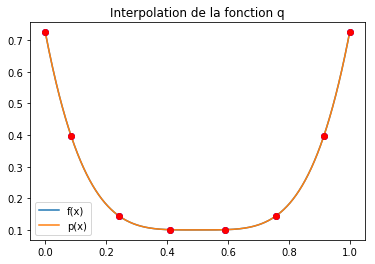

62
ftheta : [ 4.16333634e-17 -2.15105711e-16  4.62757610e-12 -4.62763855e-12
  3.19189120e-16  2.22044605e-16]


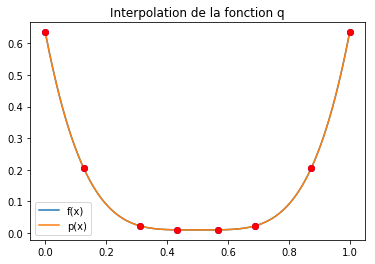

61
ftheta : [-9.58816360e-13  1.24471267e-12  2.35783615e-12 -2.35782227e-12
 -1.24455307e-12  9.58955138e-13]


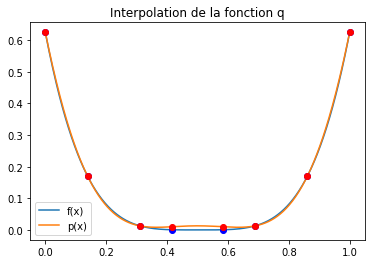

79
ftheta : [ 6.24986174e-13  2.12469625e-12  2.29830044e-12 -2.29826227e-12
 -2.12470319e-12 -6.24889029e-13]


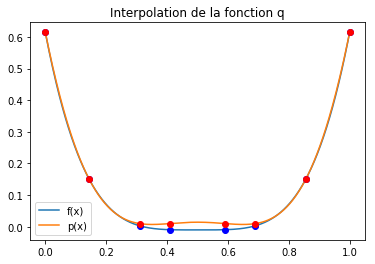

39
ftheta : [-2.68340905e-13  1.13964393e-13 -1.22499233e-12  1.22507560e-12
 -1.13978271e-13  2.68507439e-13]


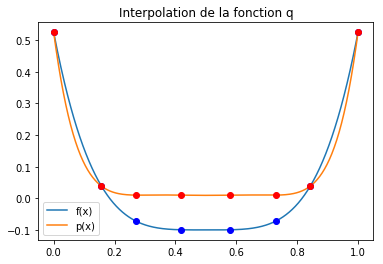

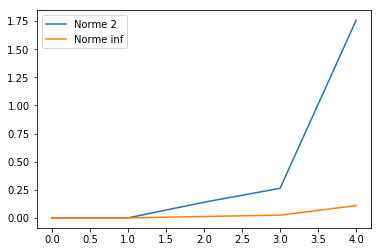

In [368]:
h = 1
p = 3
epsilon=0.01
l = [0.1,0.01,0,-0.01,-0.1]
Err = np.zeros((2,len(l)))

for i in range(len(l)):
    px,fx = test_approx(p,q,h,l[i],epsilon,1)
    Err[0,i] = npl.norm(px-fx)
    Err[1,i] = npl.norm(px-fx,np.inf)
    
plt.plot(Err[0,:],label="Norme 2")
plt.plot(Err[1,:],label="Norme inf")
plt.legend()

13
ftheta : [-2.46024772e-12  1.24496767e-12 -4.30627756e-14 -1.66533454e-16
  2.77555756e-17  7.07767178e-16  1.33226763e-15 -1.36002321e-15
  2.20601315e-13 -4.29123403e-12 -4.29847130e-12  2.19126800e-13
 -1.62023173e-15  1.04083409e-17  8.32667268e-16  5.89805982e-16
  3.46944695e-16 -4.27852198e-14  1.24601718e-12 -2.45792275e-12]


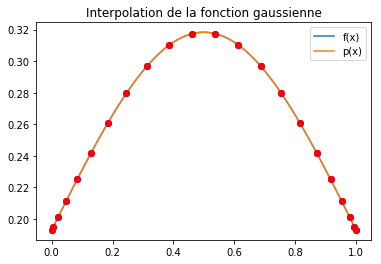

57
ftheta : [-1.61506863e-10  1.35828120e-11 -2.40779618e-15  1.59594560e-16
 -5.27355937e-16 -8.18789481e-16  5.82867088e-16 -2.77555756e-15
  2.51465515e-14 -2.02167172e-11 -2.02196315e-11  2.31880487e-14
  6.07153217e-16  3.53883589e-16  1.11716192e-15 -3.60822483e-16
  3.12250226e-16 -3.19189120e-15  1.35820938e-11 -1.61506711e-10]


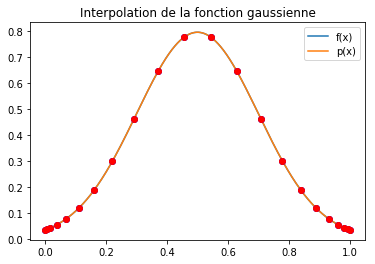

100
ftheta : [-1.31972835e-07  3.75006390e-07 -4.42867045e-07  4.94909963e-09
 -1.65232904e-09  2.90229712e-09 -3.71515095e-09  1.40597055e-08
  4.42093479e-07 -6.93012192e-07 -6.93012186e-07  4.42093480e-07
  1.40597046e-08 -3.71515105e-09  2.90229626e-09 -1.65232843e-09
  4.94909949e-09 -4.42867044e-07  3.75006389e-07 -1.31972832e-07]


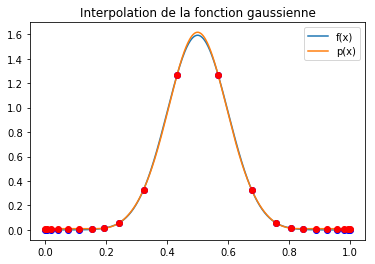

100
ftheta : [-1.40291576e-06  4.27823908e-06 -7.36748300e-06  1.08278751e-05
 -1.48162981e-05  1.93821855e-05 -2.39147230e-05  2.43718088e-05
 -3.97437185e-06  1.32948543e-06 -1.40358291e-06  3.16497024e-06
  1.82158363e-05 -3.84000735e-05  4.08226768e-05 -3.97644280e-05
  3.81819441e-05 -3.67986435e-05  3.57899908e-05 -3.51869000e-05
 -3.51869001e-05  3.57899908e-05 -3.67986435e-05  3.81819441e-05
 -3.97644280e-05  4.08226768e-05 -3.84000735e-05  1.82158363e-05
  3.16497024e-06 -1.40358291e-06  1.32948543e-06 -3.97437185e-06
  2.43718088e-05 -2.39147230e-05  1.93821855e-05 -1.48162981e-05
  1.08278751e-05 -7.36748300e-06  4.27823907e-06 -1.40291575e-06]


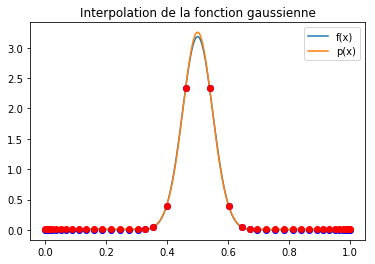

100
ftheta : [-3.48930596e-06  1.04772666e-05 -1.74933479e-05  2.45565468e-05
 -3.16862393e-05  3.89023409e-05 -4.62254764e-05  5.36771611e-05
 -6.12799991e-05  6.90578994e-05 -7.70363174e-05  8.52425247e-05
 -9.37059150e-05  1.02458353e-04 -1.11534575e-04  1.20972653e-04
 -1.30814536e-04  1.41106681e-04 -1.51900804e-04  1.63254765e-04
 -1.75233630e-04  1.87910945e-04 -2.01370275e-04  2.15707087e-04
 -2.31031053e-04  2.47468895e-04 -2.65167935e-04  2.84300549e-04
 -3.05069813e-04  3.27716731e-04 -3.52529565e-04  3.79856047e-04
 -4.10119513e-04  4.43840530e-04 -4.81666280e-04  5.24411076e-04
 -5.73113192e-04  6.29115926e-04 -6.94185458e-04  7.70685467e-04
 -8.61840656e-04  9.72140227e-04 -1.10795692e-03  1.27846307e-03
 -1.49675400e-03  1.77978988e-03 -2.13697004e-03  2.46727595e-03
 -8.83633929e-04  2.06469457e-04 -2.08763709e-04  2.66647804e-04
  1.98607489e-03 -2.46080768e-03  2.17116875e-03 -1.88633719e-03
  1.65696288e-03 -1.47600083e-03  1.33185807e-03 -1.21522739e-03
  1.11934210

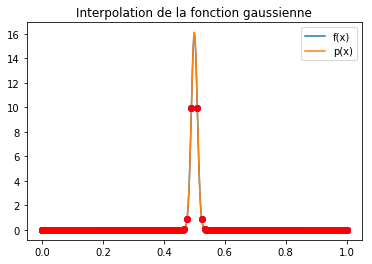

In [369]:
def gaussienne(x,h,sigma):
    x = x*h
    m = 1/2
    #sigma = 1/10
    return np.exp(-(x-m)**2/2/sigma**2) / (2*np.pi)/sigma

h = 1
p = [10,10,10,20,100]
epsilon=0.01
l = [1/2,1/5,1/10,1/20,1/100]
Err = np.zeros((2,len(l)))

for i in range(len(l)):
    px,fx = test_approx(p[i],gaussienne,h,l[i],epsilon,1)
    Err[0,i] = npl.norm(px-fx)
    Err[1,i] = npl.norm(px-fx,np.inf)
    
#plt.plot(Err[0,:],label="Norme 2")
#plt.plot(Err[1,:],label="Norme inf")
#plt.legend()

## Tests sur l'opérateur S

In [413]:
def Newton_Raphson (p,f,h,s,epsi,epsilon,eps=1e-12,itermax=100):
    X = init_X(p) 
    X = np.concatenate((X[:p],X[p+2:]))
    k=0
    err=2*eps
    Residus = []
    while err > eps and itermax > k :
        X0 = np.copy(X)
        #print(f_theta(X,p,f,h,epsilon))
        d = npl.solve(Jp(p,f,h,X,epsilon),f_theta(X,p,f,h,epsilon))
        X = X - d
        if s == 1 : 
            X = S(p,epsi,X)
        #print(f_theta(X,p,f,h,epsilon))
        k+=1
        err = npl.norm(X-X0)/npl.norm(X0)
        Residus += [err]
    #print(k)
    return X,k,Residus

def approxh(x,p,f,h,epsilon,s):
    # reconstruit le polynome le plus interpolant
    epsi = epsi_S(p)
    X,itermax,residus = Newton_Raphson(p,f,h,s,epsi,epsilon)
    X  = np.concatenate(( X[:p],[1],[0],X[p:]))
    ap = a_alpha(p,f,h,X[:p+1],x,epsilon)
    bp = b_beta(p,f,h,X[p+1:],x,epsilon)
    return pn(x,ap,bp),X

def test_approx(p,f,h,espilon,affichage,s):
    x = np.linspace(0,1,501)
    px, interp = approxh(x,p,f,h,epsilon,s)

    Ap = a_alpha(p,f,h,interp[:p+1],interp,epsilon)
    Bp = b_beta(p,f,h,interp[p+1:],interp,epsilon)
    
    fx = f(x,h) 
    
    if affichage == 1 : 
        plt.plot(x,fx,label="f(x)")
        plt.plot(x,px,label="p(x)")
        plt.plot(interp,f(interp,h),'ob')
        plt.plot(interp, pn(interp,Ap,Bp),'or')
        plt.legend()
        name = str(f).split(' ')
        plt.title("Fonction "+name[1]+", p = "+str(p)+", h = "+str(h)+", epsilon = "+str(epsilon))
        plt.show()
    
    return px,fx

In [424]:
def absolu(x,h):
    x = x*h
    return np.abs(x)

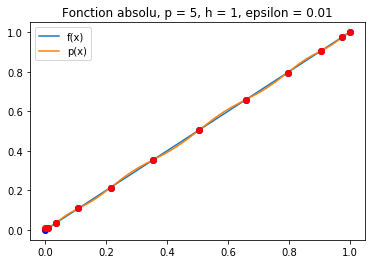

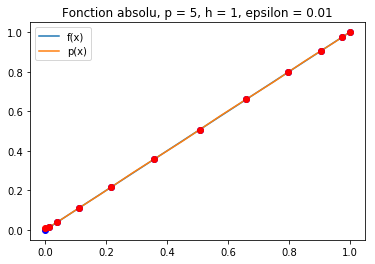

Sans opérateur Séparateur : Norme 2 : 0.1366984910415585
Avec opérateur Séparateur : Norme 2 : 0.030463596727302197


In [425]:
h = 1
p = 5
epsilon = 1e-2
sansS = test_approx(p,absolu,h,epsilon,1,0)
avecS = test_approx(p,absolu,h,epsilon,1,1)

print("Sans opérateur Séparateur : Norme 2 :", npl.norm(sansS[0]-sansS[1]))
print("Avec opérateur Séparateur : Norme 2 :", npl.norm(avecS[0]-avecS[1]))